# Querying tables

> Objectives:
> * Compare queries of tabular data for **in-memory** containers
> * Compare sizes and times for those

In [1]:
from ipython_memwatcher import MemWatcher
mw = MemWatcher()
mw.start_watching_memory()

In [1] used 0.020 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 29.785 MiB


In [2]:
import os
dset = 'movielens-1m'
fdata = os.path.join(dset, 'ratings.dat.gz')
fitem = os.path.join(dset, 'movies.dat')

In [2] used 0.027 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 29.812 MiB


In [3]:
import pandas as pd
# pass in column names for each CSV
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(fdata, sep=';', names=r_cols, compression='gzip')

m_cols = ['movie_id', 'title', 'genres']
movies = pd.read_csv(fitem, sep=';', names=m_cols,
                     dtype={'title': object, 'genres': object})

In [3] used 70.090 MiB RAM in 0.571s, peaked 0.000 MiB above current, total RAM usage 99.902 MiB


In [4]:
lens = pd.merge(movies, ratings)

In [4] used 62.434 MiB RAM in 0.119s, peaked 15.688 MiB above current, total RAM usage 162.336 MiB


In [5]:
size_pandas = mw.measurements.memory_delta
size_pandas

62.43359375

In [5] used 0.047 MiB RAM in 0.010s, peaked 0.000 MiB above current, total RAM usage 162.383 MiB


In [6]:
print(lens[:10])
lens.info()

   movie_id             title                       genres  user_id  rating  \
0         1  Toy Story (1995)  Animation|Children's|Comedy        1       5   
1         1  Toy Story (1995)  Animation|Children's|Comedy        6       4   
2         1  Toy Story (1995)  Animation|Children's|Comedy        8       4   
3         1  Toy Story (1995)  Animation|Children's|Comedy        9       5   
4         1  Toy Story (1995)  Animation|Children's|Comedy       10       5   
5         1  Toy Story (1995)  Animation|Children's|Comedy       18       4   
6         1  Toy Story (1995)  Animation|Children's|Comedy       19       5   
7         1  Toy Story (1995)  Animation|Children's|Comedy       21       3   
8         1  Toy Story (1995)  Animation|Children's|Comedy       23       4   
9         1  Toy Story (1995)  Animation|Children's|Comedy       26       3   

   unix_timestamp  
0       978824268  
1       978237008  
2       978233496  
3       978225952  
4       978226474  
5       97

In [7]:
size_pandas2 = lens.memory_usage().sum(index=True) / 2**20.
size_pandas2

45.785934448242188

In [7] used 0.000 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 176.715 MiB


In [8]:
result = lens.query("(title == 'Tom and Huck (1995)') & (rating == 5)")['user_id']
t = %timeit -o lens.query("(title == 'Tom and Huck (1995)') & (rating == 5)")['user_id']
result

10 loops, best of 3: 39.4 ms per loop


5121      75
5164    3842
5187    6031
Name: user_id, dtype: int64

In [8] used 0.215 MiB RAM in 1.693s, peaked 0.000 MiB above current, total RAM usage 176.930 MiB


In [9]:
qtime_pandas = t.best

In [9] used 0.008 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 176.938 MiB


## Use a compressed in-memory container via `bcolz`

In [10]:
import bcolz
bcolz.print_versions()
bcolz.defaults.cparams['cname'] = 'lz4'
bcolz.defaults.cparams['clevel'] = 5
bcolz.set_nthreads(4)

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
bcolz version:     0.12.1.dev2+dirty
NumPy version:     1.10.1
Blosc version:     1.4.1 ($Date:: 2014-07-08 #$)
Blosc compressors: ['blosclz', 'lz4', 'lz4hc', 'snappy', 'zlib']
Numexpr version:   2.4.7.dev0
Python version:    2.7.10 |Continuum Analytics, Inc.| (default, Oct 19 2015, 18:04:42) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
Platform:          linux2-x86_64
Byte-ordering:     little
Detected cores:    4
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


4

In [10] used 5.406 MiB RAM in 0.050s, peaked 0.000 MiB above current, total RAM usage 182.344 MiB


In [11]:
zlens = bcolz.ctable.fromdataframe(lens)

In [11] used 0.496 MiB RAM in 0.161s, peaked 44.621 MiB above current, total RAM usage 182.840 MiB


In [12]:
size_bcolz = mw.measurements.memory_delta
size_bcolz

0.49609375

In [12] used 0.008 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 182.848 MiB


Sometimes the memory reported as used is too much biased (don't know why), so let's repeat the operation, but using a different container:

In [13]:
zlens2 = bcolz.ctable.fromdataframe(lens)

In [13] used 0.121 MiB RAM in 0.151s, peaked 34.145 MiB above current, total RAM usage 182.969 MiB


In [14]:
size_bcolz2 = zlens2.cbytes / 2**20.
size_bcolz2

7.894172668457031

In [14] used 2.008 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 184.977 MiB


In [15]:
zlens

ctable((1000209,), [('movie_id', '<i8'), ('title', 'S82'), ('genres', 'S47'), ('user_id', '<i8'), ('rating', '<i8'), ('unix_timestamp', '<i8')])
  nbytes: 153.57 MB; cbytes: 7.89 MB; ratio: 19.45
  cparams := cparams(clevel=5, shuffle=True, cname='lz4')
[(1, 'Toy Story (1995)', "Animation|Children's|Comedy", 1, 5, 978824268)
 (1, 'Toy Story (1995)', "Animation|Children's|Comedy", 6, 4, 978237008)
 (1, 'Toy Story (1995)', "Animation|Children's|Comedy", 8, 4, 978233496)
 ...,
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5837, 4, 1011902656)
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5927, 1, 979852537)
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5998, 4, 1001781044)]

In [15] used -1.961 MiB RAM in 0.004s, peaked 1.965 MiB above current, total RAM usage 183.016 MiB


In [16]:
size_pandas / size_bcolz

125.85039370078741

In [16] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 183.016 MiB


We can see that the space taken by a bcolz container is more than 20x smaller (!) than a pandas one.

### Excercise

Why do you think that the number of uncompressed bytes (nbytes) that the ctable reports is 3x more than pandas (153 MB vs 54 MB)?

*Hint:* Pandas stores the string columns in NumPy containers with 'object' dtype whereas bcolz uses the equivalent to NumPy's 'string' objects.

In [17]:
# Querying a bcolz dataset
resultz = [(r.nrow__, r.user_id) for r in zlens.where("(title == b'Tom and Huck (1995)') & (rating == 5)", outcols=['nrow__', 'user_id'])]
t = %timeit -o [(r.nrow__, r.user_id) for r in zlens.where("(title == b'Tom and Huck (1995)') & (rating == 5)", outcols=['nrow__', 'user_id'])]

10 loops, best of 3: 23.6 ms per loop
In [17] used 2.141 MiB RAM in 1.025s, peaked 0.000 MiB above current, total RAM usage 185.156 MiB


In [18]:
qtime_bcolz = t.best

In [18] used 0.000 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 185.156 MiB


In [19]:
qtime_pandas / qtime_bcolz

1.6648372811492964

In [19] used 0.000 MiB RAM in 0.006s, peaked 0.000 MiB above current, total RAM usage 185.156 MiB


We see that bcolz containers, besides being in compressed state, provide ~1.3x faster query times than pandas

In [20]:
# Sanity check (always check for your results!)
print("results with pandas Dataframe:", result)
print("results with bcolz ctable:", resultz)

('results with pandas Dataframe:', 5121      75
5164    3842
5187    6031
Name: user_id, dtype: int64)
('results with bcolz ctable:', [(5121, 75), (5164, 3842), (5187, 6031)])
In [20] used 0.023 MiB RAM in 0.012s, peaked 0.000 MiB above current, total RAM usage 185.180 MiB


## Using structured NumPy arrays

In [21]:
nalens = lens.to_records()

In [21] used 53.441 MiB RAM in 0.501s, peaked 0.000 MiB above current, total RAM usage 238.621 MiB


In [22]:
size_numpy = mw.measurements.memory_delta
size_numpy

53.44140625

In [22] used 0.008 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 238.629 MiB


In [23]:
nalens

rec.array([ (0, 1, 'Toy Story (1995)', "Animation|Children's|Comedy", 1, 5, 978824268),
 (1, 1, 'Toy Story (1995)', "Animation|Children's|Comedy", 6, 4, 978237008),
 (2, 1, 'Toy Story (1995)', "Animation|Children's|Comedy", 8, 4, 978233496),
 ...,
 (1000206, 3952, 'Contender, The (2000)', 'Drama|Thriller', 5837, 4, 1011902656),
 (1000207, 3952, 'Contender, The (2000)', 'Drama|Thriller', 5927, 1, 979852537),
 (1000208, 3952, 'Contender, The (2000)', 'Drama|Thriller', 5998, 4, 1001781044)], 
          dtype=[('index', '<i8'), ('movie_id', '<i8'), ('title', '|O'), ('genres', '|O'), ('user_id', '<i8'), ('rating', '<i8'), ('unix_timestamp', '<i8')])

In [23] used 0.020 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 238.648 MiB


In [24]:
size_numpy2 = round((nalens.size * nalens.dtype.itemsize) / 2**20., 3)
size_numpy2

53.417

In [24] used 0.000 MiB RAM in 0.017s, peaked 0.000 MiB above current, total RAM usage 238.648 MiB


In [25]:
resultna = nalens[(nalens['title'] == 'Tom and Huck (1995)') & (nalens['rating'] == 5)]
t = %timeit -o nalens[(nalens['title'] == 'Tom and Huck (1995)') & (nalens['rating'] == 5)]
resultna

100 loops, best of 3: 16.9 ms per loop


rec.array([ (5121, 8, 'Tom and Huck (1995)', "Adventure|Children's", 75, 5, 977851520),
 (5164, 8, 'Tom and Huck (1995)', "Adventure|Children's", 3842, 5, 967986151),
 (5187, 8, 'Tom and Huck (1995)', "Adventure|Children's", 6031, 5, 956718223)], 
          dtype=[('index', '<i8'), ('movie_id', '<i8'), ('title', '|O'), ('genres', '|O'), ('user_id', '<i8'), ('rating', '<i8'), ('unix_timestamp', '<i8')])

In [25] used 2.047 MiB RAM in 6.990s, peaked 0.000 MiB above current, total RAM usage 240.695 MiB


Again, NumPy works the fastest for in-memory data containers, while memory consumption is close to pandas.

In [26]:
qtime_numpy = t.best

In [26] used 0.023 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 240.719 MiB


## Performance comparsion

In [27]:
%matplotlib inline

In [27] used 7.504 MiB RAM in 0.082s, peaked 0.000 MiB above current, total RAM usage 248.223 MiB


/home/faltet/miniconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family [u'monospace'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


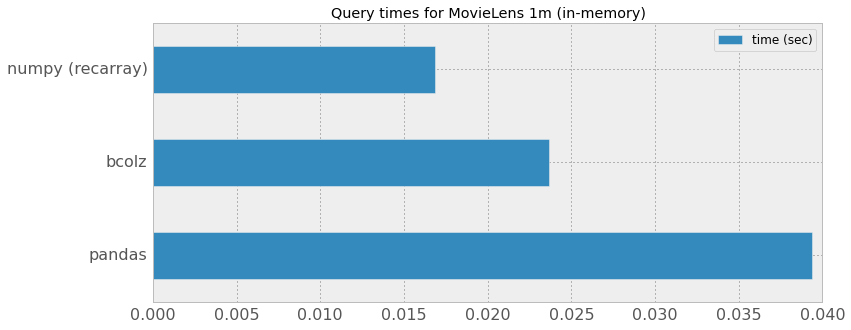

In [28] used 12.828 MiB RAM in 0.315s, peaked 0.000 MiB above current, total RAM usage 261.051 MiB


In [28]:
# Query times
labels = ["pandas", "bcolz", "numpy (recarray)"]
df = pd.DataFrame({'time (sec)': [qtime_pandas, qtime_bcolz, qtime_numpy]}, index=labels)
pd.options.display.mpl_style = 'default'
df.plot(kind='barh', figsize=(12,5), fontsize=16, title="Query times for MovieLens 1m (in-memory)")

## Size comparison

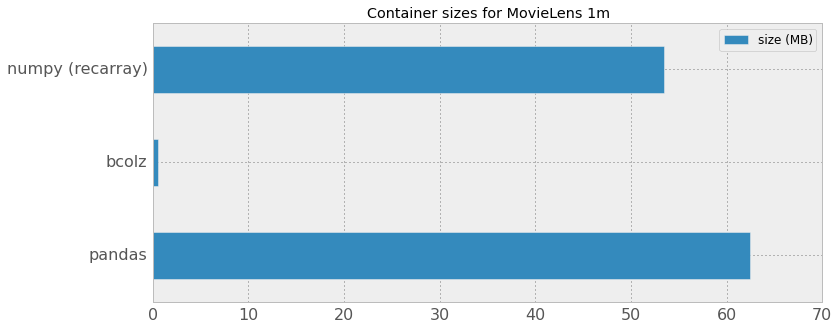

In [29] used 2.980 MiB RAM in 0.221s, peaked 0.000 MiB above current, total RAM usage 264.031 MiB


In [29]:
# Container sizes
df = pd.DataFrame({'size (MB)': [size_pandas, size_bcolz, size_numpy]}, index=labels)
pd.options.display.mpl_style = 'default'
df.plot(kind='barh', figsize=(12,5), fontsize=16, title="Container sizes for MovieLens 1m")

## Rules of thumb for querying in-memory tabular datasets

* Choose pure NumPy recarrays if you need the fastest speed
* Choose bcolz ctables if you need to store lots of data in limited memory and not want to loose too much speed
* Choose pandas if what you need is rich functionality on top of your containers (at the penalty of some speed)